In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Dados carregados em um numpy array
data = np.loadtxt('cluster.dat')

In [3]:
# Dados normalizados que serão utilizados como uma comparação 
data_norm = data/data.max(axis=0)

In [4]:
# divisão para dados de treinamento e dados de teste
np.random.shuffle(data_norm)
train_index_norm = int(data_norm.shape[0]*0.9)
train_data_norm,test_data_norm = np.vsplit(data_norm,[train_index_norm])

In [5]:
def dbscan(data_in: np.ndarray, radius_of_neighborhood: float, number_of_neighbors: int) -> np.ndarray:
    #inicialização da lista de classificação dos pontos
    core_points = []
    border_points = []
    outliers_points = []

    #cluster ajudará na cassificação dos cores junto aos clusters, os dois dicionários serão retornados
    cluster = 0
    cluster_cores = {}
    cluster_borders = {}

    #mepamento de todos os pontos do dataset, mantem a lista de quais não foram visitados ainda
    availabe_points = []
    for i in range(data_in.shape[0]):
        availabe_points.append(i)
    
    #escolha aleatoria de um ponto
    index_list = [np.random.choice(data_in.shape[0])]
    
    #enquanto ainda houver pontos não visitados, este laço é executado
    while True:
        
        #se existe elemento em index_list, ele retira o topo e continua o processamento
        #se não ele escolhe um aleatório dos pontos disponíveis
        if index_list:
            point = index_list.pop(0)
        else:
            if core_points:
                #etapa para verificar se outliers realmente são outliers levando em consideração os dicionários de corepoints formados
                for i in outliers_points:
                    
                    #calcula a distância entre o ponto escolhido e todos os outros do dataset
                    dist = np.linalg.norm(data_in[i]-data_in[core_points],axis=1)

                    neighbors = np.where(dist <= radius_of_neighborhood)[0]

                    core_neighbor_flag = 0
                    for i in neighbors:
                        if not core_neighbor_flag and i in core_points:
                            core_neighbor_flag = 1

                    #se algum dos vizinhos deste "outlier" em questão for core, ele é reclassificado como border
                    if core_neighbor_flag:
                        border_points.append(i)
                        outliers_points.remove(i)

                # Podemos montar os dicionários dos clusters, classificando como um novo cluster, iterando a variável cluster, 
                # já que chegamos em todos os pontos alcançáveis de acordo com os parâmetros passados para a função
            
                cluster_cores[cluster] = np.array(core_points)
                cluster_borders[cluster] = np.array(border_points)
                cluster += 1

                #limpeza das listas já classificadas em um cluster
                core_points.clear()
                border_points.clear()

            #se ainda existem pontos disponíveis
            if availabe_points:
                #escolha de um ponto aleatório dentro dos pontos disponíveis
                point = availabe_points[np.random.choice(len(availabe_points))]
            else:
                #saia do loop se acabarem os pontos disponíveis
                break
        
        #remove o ponto utilizado da lista de pontos disponíveis
        availabe_points.remove(point)
        
        #calcula a distância entre o ponto escolhido e todos os outros do dataset
        dist = np.linalg.norm(data_in[point]-data_in,axis=1)

        #identifica os vizinhos do ponto escolhido de acordo com o raio passado como parâmetro
        neighbors = np.where(dist <= radius_of_neighborhood)[0]
        
        #adiciona todos os pontos alcancáveis pelo ponto escolhido se ele ainda não foi processado e se ele já não está presente em index_list
        # identifica se algum dos vizinhos é um core point, vai ser importante para a classificação como border.
        core_neighbor_flag = 0
        for i in neighbors:
            if (i in availabe_points) and (i not in index_list):
                index_list.append(i)
            if not core_neighbor_flag and i in core_points:
                core_neighbor_flag = 1

        #classificação dos pontos
        if neighbors.shape[0] >= number_of_neighbors:
            core_points.append(point)
        elif core_neighbor_flag:
            border_points.append(point)
        else:
            outliers_points.append(point)

    return cluster_cores, cluster_borders, outliers_points, cluster


def dbscan_fit(test_data: np.ndarray, core_dict: dict, radius_of_neighborhood: float, train_data: np.ndarray):
    test_clusters = {}
    outliers_found = []
    availabe_points = []

    for i in range(test_data.shape[0]):
        availabe_points.append(i)

    for cluster,cores in core_dict.items():
        test_clusters[cluster] = []
        for index in range(test_data.shape[0]):

            dist = np.linalg.norm(train_data[cores]-test_data[index],axis=1)
            if (dist <= radius_of_neighborhood).any():
                test_clusters[cluster].append(index)
                availabe_points.remove(index)

    while availabe_points:
        outliers_found.append(availabe_points.pop())


    return test_clusters, outliers_found

In [6]:
radius = 0.058
nb_of_neighbors = 7

In [7]:
core_train, border_train, outlier_train, n = dbscan(data_in = train_data_norm, radius_of_neighborhood = radius, number_of_neighbors = nb_of_neighbors) 


In [8]:
colors = cm.rainbow(np.linspace(0,1,n))

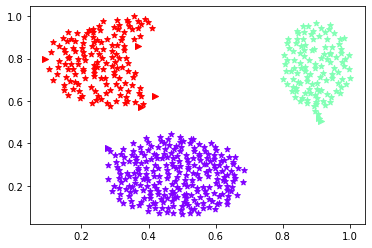

In [9]:
figure, axes = plt.subplots()
for value,color in zip(core_train.values(),colors):
    if value.size:
        x_core, y_core = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_core,y_core,marker='*',color=color)
for value,color in zip(border_train.values(),colors):
    if value.size:
        x_border, y_border = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_border,y_border,marker='>',color=color)
x_outlier, y_outlier = np.hsplit(train_data_norm[outlier_train], 2)
plt.scatter(x_outlier,y_outlier,marker='x',color=color)
draw_circle = []
j = 0
for i in range(x_outlier.shape[0]):
    draw_circle.append(plt.Circle((x_outlier[i,0], y_outlier[i,0]), radius, fill=False))
    axes.add_artist(draw_circle[j])
    j += 1
plt.show()

In [10]:
test_result, test_outlier = dbscan_fit(test_data=test_data_norm, core_dict=core_train, radius_of_neighborhood=radius, train_data = train_data_norm)

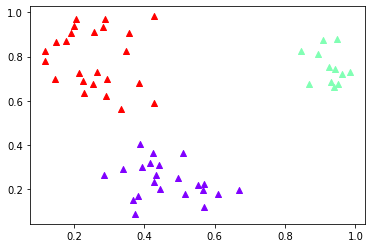

In [11]:
for value,color in zip(test_result.values(),colors):
    x_train, y_train = np.hsplit(test_data_norm[value], 2)
    plt.scatter(x_train,y_train,marker='^',color=color)
x_outlier_test, y_outlier_test = np.hsplit(test_data_norm[test_outlier], 2)
plt.scatter(x_outlier_test,y_outlier_test,marker='x',color='g')

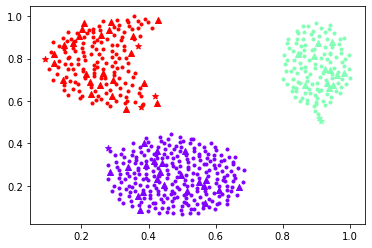

In [12]:
for value,color in zip(core_train.values(),colors):
    x_core, y_core = np.hsplit(train_data_norm[value], 2)
    plt.scatter(x_core,y_core,marker='.',color=color)
for value,color in zip(border_train.values(),colors):
    if value.size:
        x_border, y_border = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_border,y_border,marker='*',color=color)
for value,color in zip(test_result.values(),colors):
    x_test, y_test = np.hsplit(test_data_norm[value], 2)
    plt.scatter(x_test,y_test,marker='^',color=color)
x_outlier_train, y_outlier_train = np.hsplit(train_data_norm[outlier_train], 2)
x_outlier_test, y_outlier_test = np.hsplit(test_data_norm[test_outlier], 2)

plt.scatter(x_outlier_train,y_outlier_train,marker='x',color='r')
plt.scatter(x_outlier_test,y_outlier_test,marker='x',color='g')
plt.show()